In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np 
import glob, os, subprocess
from dateutil import parser

import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, shutil
sys.path.append("..")

from SRC import *

%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams['savefig.dpi'] = 300


indir = '../MULLION/20MAR20/FLAME/SPECTRA/AVG/'
outdir = '../PNGS/MULLION/20MAR20/'
calfile = '../CALIBRATION/RadCalCoeff_GT08_.csv'
#TelemetryFile = '/g/data/u46/users/aw3463/GuyByrne/calval/FLAME/MULLION/20MAR20/TELEMETRY/Feb-20th-2020-12-46PM-Flight-Airdata.csv'

field_data = ['MUL', '20MAR20', '', 'Sentinel2a', 'GA 10inch Panel 99aa03-0319-1952', 'Radiance', '', '']

fignum=1

firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 132

plot_scale = [0.0, 1.0, 0.0, 1.0]
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'
panel_dir =  '../../../CalVal_Phase1/RAW_DATA/Panels/'
in_panel = 'GA_10inch.txt'

sat_resp = dict({'Landsat5': '../../../CalVal_Phase1/SENSOR_BANDS/landsat5_vsir.flt', 
            'Landsat7': '../../../CalVal_Phase1/SENSOR_BANDS/landsat7_vsir.flt', 
            'Landsat8': '../../../CalVal_Phase1/SENSOR_BANDS/landsat8_vsir.flt',
            'Sentinel2a': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2a.flt',
            'Sentinel2b': '../../../CalVal_Phase1/SENSOR_BANDS/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']



In [2]:
#TeleDat = pd.read_csv(TelemetryFile)

TeleDat.drop(['height_above_ground_at_drone_location(meters)', 
              'ground_elevation_at_drone_location(meters)',
              'satellites',
              'gpslevel',
              'voltage(v)',
              'max_altitude(meters)',
              'max_ascent(meters)',
              'max_speed(m/s)',
              'max_distance(meters)',
              ' xSpeed(m/s)',
              ' ySpeed(m/s)',
              ' zSpeed(m/s)',
              'isPhoto',
              'isVideo',
              'rc_elevator',
              'rc_aileron',
              'rc_throttle',
              'rc_rudder',
              'battery_percent',
              'voltageCell1',
              'voltageCell2',
              'voltageCell3',
              'voltageCell4',
              'voltageCell5',
              'voltageCell6',
              'current(A)',
              'battery_temperature(c)',
              'altitude(meters)',
              'ascent(meters)',
              'flycStateRaw',
              'flycState'], axis=1, inplace=True)

TeleDat.rename(columns={'time(millisecond)': 'time_ms',
                        'datetime(utc)': 'datetime',
                        'height_above_takeoff(meters)': 'height_local',
                        'altitude_above_seaLevel(meters)': 'height_sea',
                        'distance(meters)': 'distance(m)',
                        ' compass_heading(degrees)': 'compass_heading',
                        ' pitch(degrees)': 'pitch',
                        ' roll(degrees)': 'roll',
                        'gimbal_heading(degrees)': 'gimbal_heading',
                        'gimbal_pitch(degrees)': 'gimbal_pitch',
                        'message': 'comment'
                       }, inplace=True
              )

TeleDat['date_saved'] = [parser.parse(TeleDat.datetime[i]) - timedelta(minutes=21) + timedelta(milliseconds=int(TeleDat.time_ms[i])) for i in range(len(TeleDat.datetime))]

TeleDat = TeleDat[TeleDat.latitude!=0]

TeleDat = TeleDat[TeleDat.date_saved.dt.year >= 2020]

TeleDat.date_saved.unique()

alldata['latitude'] = [TeleDat.latitude[int((i - TeleDat.date_saved).abs().argsort()[:1].values)] for i in alldata.date_saved]

In [3]:
alldata = LoadData.load_from_dir(indir, calfile)

In [4]:
#alldata[alldata.index == 349.176].plot('date_saved', 'radiance')

In [5]:
alldata['radiance'] = (alldata.DN-476)*alldata.CalData/alldata.IntTime
#alldata['radiance'] = alldata['radiance']/10000
alldata['Line'] = 1
alldata['Latitude'] = -35.123277
alldata['Longitude'] = 148.862692

In [6]:
#
# Bin spectra into integer wavelength bins, assuming that the input data
# has 0.3nm channels.
#
def wavelength_bin(alldata):
    # Create avgdata DataFrame, based on alldata input DataFrame
    # Reset index so that Wavelength is not the index.
    avgdata = alldata.copy()
    avgdata.reset_index(inplace=True)
    
    ### Make a mean of three rows for each of DN, Calibration, Radiance
    ###avgdata['DNmean'] = avgdata.DN.rolling(3, center=True).mean()
    ###avgdata['Calmean'] = avgdata.CalData.rolling(3, center=True).mean()
    ###avgdata['Radmean'] = avgdata.radiance.rolling(3, center=True).mean()
    
    # Remove first and last wavelengths which have NaNs in them.
    avgdata = avgdata[avgdata.Wavelength != 349.176]
    avgdata = avgdata[avgdata.Wavelength != 910.925]
    
    # Create empty output DataFrame
    outputDF = pd.DataFrame()
    ttmm = pd.DataFrame()
    
    # Loop through each spectrum in the dataframe
    for j in avgdata.SpecNum.unique():
        tempdata = avgdata[avgdata.SpecNum==j].groupby(pd.cut(avgdata[avgdata.SpecNum==j]['Wavelength'], np.arange(349.5,910.5,1.0))).mean()
        tempdata['date_saved'] = avgdata[avgdata.SpecNum==j].date_saved.values[0]
        tempdata['filename'] = avgdata[avgdata.SpecNum==j].filename.values[0]
        
        tempdata.index.rename('plop', inplace=True)
        tempdata.reset_index(inplace=True)
        tempdata.drop(columns='plop', inplace=True)
        tempdata.Wavelength = tempdata.Wavelength.round(0).astype(int)        
        
        # When finished making an entire spectrum, add it to the output DataFrame
        # and print how many have been done.
        if outputDF.empty:
            outputDF = tempdata.copy()
        
        else:
            if j % 100 == 0:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
                ttmm = pd.DataFrame()
            
            elif j == len(avgdata.SpecNum.unique())-1:
                ttmm = pd.concat([ttmm, tempdata])
                outputDF = pd.concat([outputDF, ttmm])
            
            elif ttmm.empty:
                ttmm = tempdata.copy()
            
            else:
                ttmm = pd.concat([ttmm, tempdata])
                
            
        print('Completed ', j+1, '/', len(avgdata.SpecNum.unique()), ' spectra', end='\r', flush=True)

    # output final DataFrame
    return outputDF

avgdata = wavelength_bin(alldata)

In [7]:
cutavgdata = avgdata[np.logical_and(avgdata.date_saved > datetime(2020,3,20,0,23,30), avgdata.date_saved < datetime(2020,3,20,0,58,45))]

In [8]:
panel_names, all_panels, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(cutavgdata)

In [9]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)

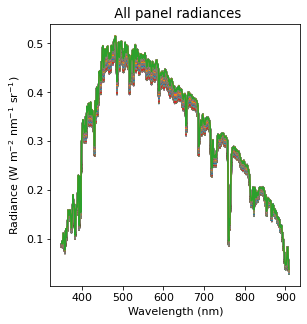

In [10]:
FIG_PanelRadiances.FIG_panel_radiances(all_panel_spec, outdir, field_data, fignum)

fignum += 1

In [11]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)

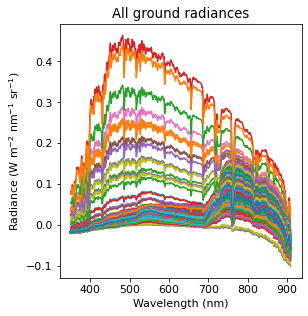

In [12]:
FIG_GroundSpectra.FIG_ground_spectra(all_grounds_spec, outdir, field_data, fignum)
fignum +=1

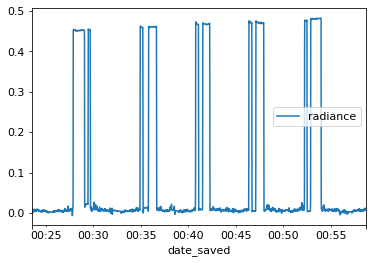

In [13]:
cutavgdata[abs(cutavgdata.Wavelength-450)<0.185].plot('date_saved', 'radiance')

In [14]:
allASDdata = pd.read_pickle('../MULLION/20MAR20/ASD/alldat.pick')

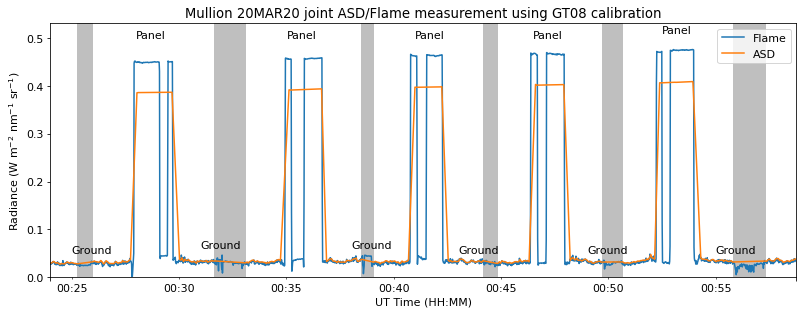

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 5.5))
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)
avgdata[abs(avgdata.Wavelength-550)<0.185].plot('date_saved', 'radiance', ax=axes)
allASDdata[allASDdata.Wavelength==550].plot('date_saved', 'radiance', ax=axes)
axes.set_ylim(0.0,0.53)
axes.set_xlim(datetime(2020,3,20,0,24), datetime(2020,3,20,0,58,45))
plt.legend(['Flame', 'ASD'])
plt.xlabel('UT Time (HH:MM)')
plt.ylabel('Radiance (W m$^{-2}$ nm$^{-1}$ sr$^{-1}$)')
plt.title('Mullion 20MAR20 joint ASD/Flame measurement using GT08 calibration')
axes.text(datetime(2020,3,20,0,25), 0.05, 'Ground')
axes.text(datetime(2020,3,20,0,28), 0.5, 'Panel')
axes.text(datetime(2020,3,20,0,31), 0.06, 'Ground')
axes.text(datetime(2020,3,20,0,35), 0.5, 'Panel')
axes.text(datetime(2020,3,20,0,38), 0.06, 'Ground')
axes.text(datetime(2020,3,20,0,41), 0.5, 'Panel')
axes.text(datetime(2020,3,20,0,43), 0.05, 'Ground')
axes.text(datetime(2020,3,20,0,46,30), 0.5, 'Panel')
axes.text(datetime(2020,3,20,0,49), 0.05, 'Ground')
axes.text(datetime(2020,3,20,0,52,30), 0.51, 'Panel')
axes.text(datetime(2020,3,20,0,55), 0.05, 'Ground')

axes.axvspan(datetime(2020,3,20,0,25,15), datetime(2020,3,20,0,26), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,31,38), datetime(2020,3,20,0,33,6), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,38,29), datetime(2020,3,20,0,39,4), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,44,9), datetime(2020,3,20,0,44,51), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,49,43), datetime(2020,3,20,0,50,40), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,55,47), datetime(2020,3,20,0,57,19), alpha=0.25, color='black', ec=None)

plt.savefig('plonk1.png')

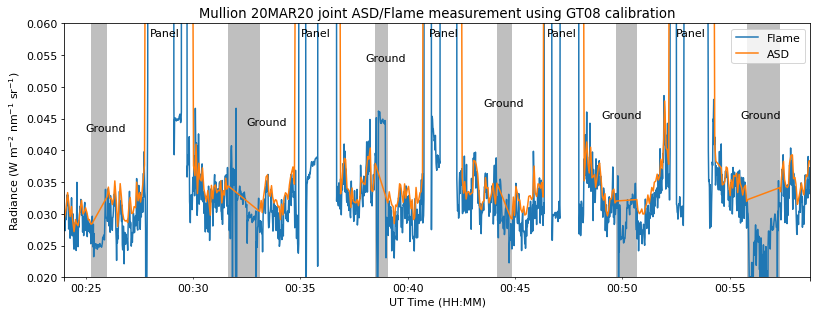

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 5.5))
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)
avgdata[abs(avgdata.Wavelength-550)<0.185].plot('date_saved', 'radiance', ax=axes)
allASDdata[allASDdata.Wavelength==550].plot('date_saved', 'radiance', ax=axes)
axes.set_ylim(0.02,0.06)
axes.set_xlim(datetime(2020,3,20,0,24), datetime(2020,3,20,0,58,45))
plt.legend(['Flame', 'ASD'])
plt.xlabel('UT Time (HH:MM)')
plt.ylabel('Radiance (W m$^{-2}$ nm$^{-1}$ sr$^{-1}$)')
plt.title('Mullion 20MAR20 joint ASD/Flame measurement using GT08 calibration')
axes.text(datetime(2020,3,20,0,25), 0.043, 'Ground')
axes.text(datetime(2020,3,20,0,28), 0.058, 'Panel')
axes.text(datetime(2020,3,20,0,32,30), 0.044, 'Ground')
axes.text(datetime(2020,3,20,0,35), 0.058, 'Panel')
axes.text(datetime(2020,3,20,0,38), 0.054, 'Ground')
axes.text(datetime(2020,3,20,0,41), 0.058, 'Panel')
axes.text(datetime(2020,3,20,0,43,30), 0.047, 'Ground')
axes.text(datetime(2020,3,20,0,46,30), 0.058, 'Panel')
axes.text(datetime(2020,3,20,0,49), 0.045, 'Ground')
axes.text(datetime(2020,3,20,0,52,30), 0.058, 'Panel')
axes.text(datetime(2020,3,20,0,55,30), 0.045, 'Ground')

axes.axvspan(datetime(2020,3,20,0,25,15), datetime(2020,3,20,0,26), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,31,38), datetime(2020,3,20,0,33,6), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,38,29), datetime(2020,3,20,0,39,4), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,44,9), datetime(2020,3,20,0,44,51), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,49,43), datetime(2020,3,20,0,50,40), alpha=0.25, color='black', ec=None)
axes.axvspan(datetime(2020,3,20,0,55,47), datetime(2020,3,20,0,57,19), alpha=0.25, color='black', ec=None)

plt.savefig('plonk2.png')

In [17]:
allASDdata[allASDdata.Wavelength==450]

Wavelength  radiance                  filename          date_saved  \
100         450  0.381556   Mull_line100000.asd.rad 2020-03-20 00:21:25   
100         450  0.381416   Mull_line100001.asd.rad 2020-03-20 00:21:29   
100         450  0.381970   Mull_line100002.asd.rad 2020-03-20 00:22:01   
100         450  0.381150   Mull_line100003.asd.rad 2020-03-20 00:22:04   
100         450  0.382644   Mull_line100004.asd.rad 2020-03-20 00:23:15   
..          ...       ...                       ...                 ...   
100         450  0.017566  Mull_line4b00023.asd.rad 2020-03-20 00:58:41   
100         450  0.017999  Mull_line4b00024.asd.rad 2020-03-20 00:58:45   
100         450  0.014990  Mull_line4b00025.asd.rad 2020-03-20 00:58:48   
100         450  0.416068  Mull_line4b00026.asd.rad 2020-03-20 00:59:06   
100         450  0.415733  Mull_line4b00027.asd.rad 2020-03-20 00:59:09   

      Latitude   Longitude  Line  Spec_number Inst_number  
100 -35.123277  148.862692     1            0     18179/2  
100 -35.123277  148.862692     1            1     18179/2  
100 -35.123277  148.862692     1            2     18179/2  
100 -35.123277  148.862692     1            3     18179/2  
100 -35.123277  148.862692     1            4     18179/2  
..         ...         ...   ...          ...         ...  
100 -35.123277  148.862692    12           23     18179/2  
100 -35.123277  148.862692    12           24     18179/2  
100 -35.123277  148.862692    12           25     18179/2  
100 -35.123277  148.862692    12           26     18179/2  
100 -35.123277  148.862692    12           27     18179/2  

[360 rows x 9 columns]

In [18]:
avgdata.to_pickle('avgdata.pick')

In [19]:
all_panels, all_grounds = SolarAngle.solar_angle(all_panels, all_grounds, field_data)

../SRC/SolarAngle.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_spectra['Solar_angle'] = 1.0
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
all_panels = PanelBRF.Panel_BRF(all_panels, field_data)

In [21]:
good_panels = all_panels.copy()
good_grounds = all_grounds.copy()

In [22]:
gpta, adta = CreateTimeRelativeDF.create_time_relative_dfs(all_panels, all_grounds)

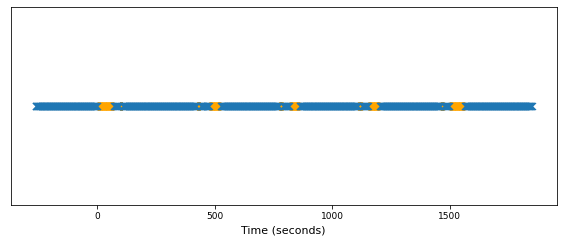

In [23]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, outdir, field_data, fignum)
fignum += 1

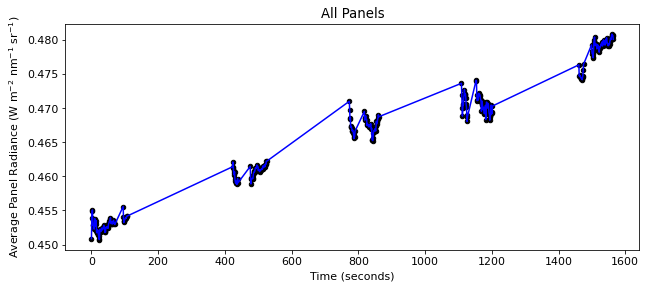

In [24]:
all_panel_mean = all_panel_spec.mean(axis=1)

gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(all_panel_mean, all_panel_spec, gpta, field_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpta, outdir, field_data, fignum)

fignum += 1

In [25]:
gpta['Latitude'] = -35.123277
gpta['Longitude'] = 148.862692
adta['Latitude'] = -35.123277
adta['Longitude'] = 148.862692

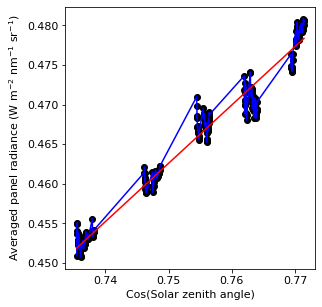

In [26]:
slope, intercept, coszenith = FIG_InsolationFit.FIG_insolation_fit(gpta, outdir, field_data, fignum)
fignum += 1

### Scale good panels to insolation curve

Use the fitted insolation curve to determine individual offsets for each panel measurement and then divide<BR>
off the differences. This effectively removes any individual variations in the absolute scaling of panel<BR>
measurements.

In [27]:
good_panels = ScalePanels.scale_panels(slope, intercept, coszenith, gpta, good_panels, field_data)

### Scale ground spectra to insolation curve

For each line, calculate the mean panel spectrum and determine the fit at the according mean Solar zenith angle.<BR>
Then determine individual fits for all ground data within the line and apply the ratio of the panel mean fit to<BR>
ground fit to the good_grounds dataframe.

In [28]:
good_grounds = ScaleGrounds.scale_grounds(good_panels, good_grounds, slope, intercept, field_data)

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [29]:
k_f = KFactor.k_factor(panel_dir, in_panel)

In [30]:
k_f = k_f[k_f.index <910]

### Re-Make Spectral Dataframes

After re-scaling of both good_panels and good_grounds, recreate the good_panel_spec and<BR>
good_grounds_spec dataframes

In [31]:
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [32]:
SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, field_data)

In [33]:
good_panel_spec = good_panel_spec.rename(columns={x:y for x,y in zip(good_panel_spec.columns,range(len(good_panel_spec.columns)))}).add_prefix('radiance1-')
good_grounds_spec = good_grounds_spec.rename(columns={x:y for x,y in zip(good_grounds_spec.columns,range(len(good_grounds_spec.columns)))}).add_prefix('radiance1-')


### Create dataframe with Reflectances

In [34]:
all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f, field_data)

../SRC/CreateReflectances.py:50: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  line_refls = pd.np.multiply(refl_tmp, k_f)


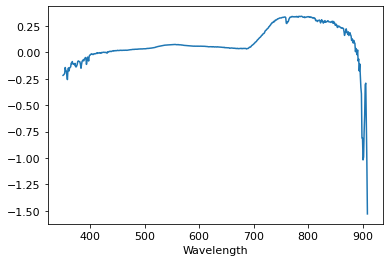

In [35]:
all_refls.mean(axis=1).plot()

In [36]:
blac = MakeSpecDF.make_spec_df(avgdata)

In [37]:
all_grounds_trunc = all_grounds_spec.copy()
for i in all_grounds_trunc.columns:
    if all_grounds_trunc[i].iloc[0] > 0.025:
        all_grounds_trunc.drop(i, axis=1, inplace=True)

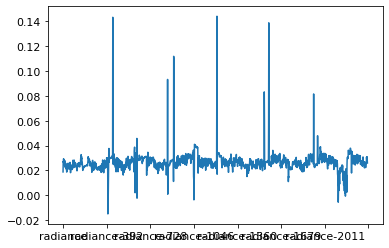

In [38]:
all_grounds_trunc.mean(axis=0).plot()

(737504.0159722222, 737504.0409722222)

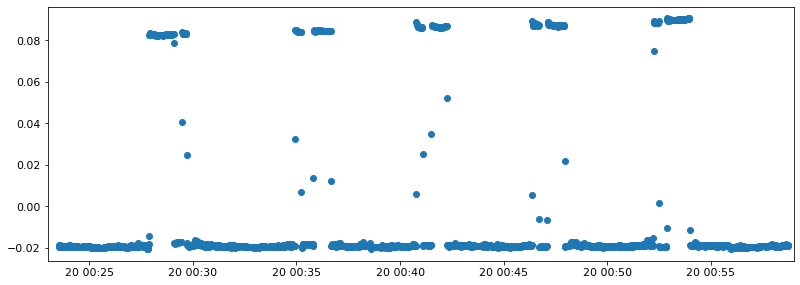

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 5.5))
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)
plt.scatter(cutavgdata[cutavgdata.Wavelength==350].date_saved, cutavgdata[cutavgdata.Wavelength==350].radiance)
#allASDdata[allASDdata.Wavelength==350].plot('date_saved', 'radiance', ax=axes)
#axes.set_ylim(0.0,0.005)
axes.set_xlim(datetime(2020,3,20,0,23), datetime(2020,3,20,0,59))

In [40]:
plop = avgdata[np.logical_and(avgdata.date_saved > datetime(2020,3,20,0,27,53), avgdata.date_saved < datetime(2020,3,20,0,29))]

In [41]:
plopmean = MakeSpecDF.make_spec_df(plop)

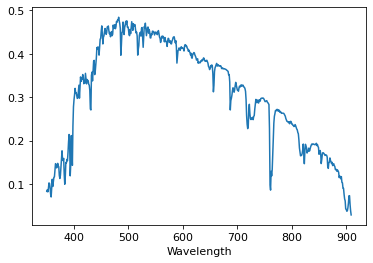

In [42]:
plopmean.mean(axis=1).plot()

In [43]:
ASDplop = allASDdata[np.logical_and(allASDdata.date_saved > datetime(2020,3,20,0,27,53), allASDdata.date_saved < datetime(2020,3,20,0,29))]

In [44]:
ASDplop = ASDplop.rename(columns={'Spec_number': 'SpecNum'})

In [45]:
ASDplopmean = MakeSpecDF.make_spec_df(ASDplop)

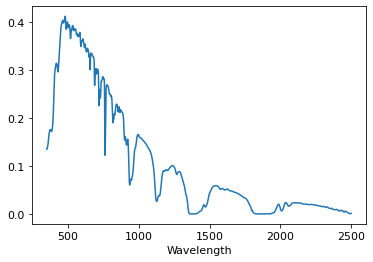

In [46]:
ASDplopmean.mean(axis=1).plot()

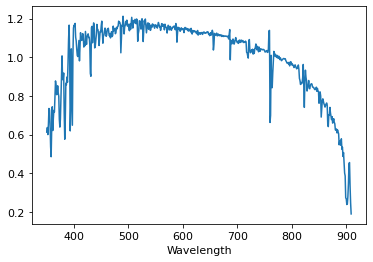

In [47]:
(plopmean.mean(axis=1)/ASDplopmean.mean(axis=1)).plot()

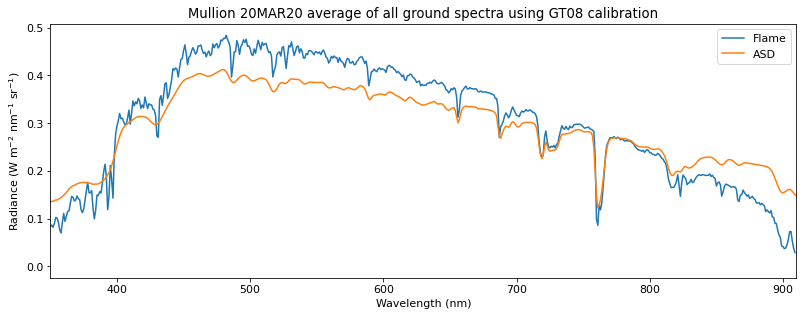

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12.5, 5.5))
plt.tight_layout(pad=5.5, w_pad=1.0, h_pad=1.0)
plopmean.mean(axis=1).plot(ax=axes)
ASDplopmean.mean(axis=1).plot(ax=axes)
#axes.set_ylim(0.0,0.05)
axes.set_xlim(350,910)
plt.legend(['Flame','ASD'])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance (W m$^{-2}$ nm$^{-1}$ sr$^{-1}$)')
plt.title('Mullion 20MAR20 average of all ground spectra using GT08 calibration')

plt.savefig('plonk0.png')

In [49]:
DarkCurrent = pd.read_csv('../CALIBRATION/FLAME_calibration_GA_ORIGINAL/Analysed/Analysed/DC_GT8.csv')

In [50]:
DarkCurrent.set_index('wl', inplace=True)